<center><h1>1-cd: Convolutional Neural Networks (ConvNets)</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


In [1]:
%run utils.py

In [2]:
import argparse
import os
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from utils import accuracy, AverageMeter, TrainLossPlot, AccLossPlot

PRINT_INTERVAL = 2_000_000
PATH = "datasets"
cuda = torch.cuda.is_available()

# Training _from scratch_ of the model


In [3]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0)  # batch size
        output = self.features(input)  # output of the conv layers
        output = output.view(bsize, -1)  # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output)  # we compute the output of the fc layers
        return output


def get_dataset(batch_size, cuda=False, transform=None):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    download = False
    if not os.path.isfile(f"{PATH}/cifar-10-python.tar.gz"):
        download = True

    if transform == "normalize":
        transform_train = transform_test = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201]),
            ]
        )
    elif transform == "augmentation":
        transform_train = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.RandomCrop(28),
                transforms.RandomHorizontalFlip(),
            ]
        )
        transform_test = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(28)])
    else:
        transform_train = transform_test = transforms.Compose([transforms.ToTensor()])

    train_dataset = datasets.CIFAR10(
        PATH,
        train=True,
        download=download,
        transform=transform_train,
    )
    val_dataset = datasets.CIFAR10(
        PATH,
        train=False,
        download=download,
        transform=transform_test,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=cuda,
        num_workers=2,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=cuda,
        num_workers=2,
    )

    return train_loader, val_loader


def epoch(data, model, criterion, optimizer=None, cuda=False, plot=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):
        if cuda:  # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer and plot:
            loss_plot.update(avg_loss.val)
        # print info
        # if i % PRINT_INTERVAL == 0:
        #     print('[{0:s} Batch {1:03d}/{2:03d}]\t'
        #           'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
        #           'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
        #           'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
        #           'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
        #            "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
        #            top1=avg_top1_acc, top5=avg_top5_acc))
        #     if optimizer and plot:
        #         loss_plot.plot()

    # Print summary
    # print('\n===============> Total time {batch_time:d}s\t'
    #       'Avg loss {loss.avg:.4f}\t'
    #       'Avg Prec@1 {top1.avg:5.2f} %\t'
    #       'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
    #        batch_time=int(avg_batch_time.sum), loss=avg_loss,
    #        top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(
    batch_size=128,
    lr=0.1,
    epochs=5,
    cuda=False,
    scheduler=False,
    save_name=None,
    transform=None,
):
    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr)
    if scheduler:
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda, transform)

    # init plots
    plot = AccLossPlot()
    # global loss_plot
    # loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in tqdm(range(epochs)):
        # print("=================\n==== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        if scheduler:
            scheduler.step()
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)
    # plot.plot(save_name)
    return plot

In [6]:
BATCH_SIZE = 32
LR = 0.01
plots = {}

for lr in [2**n for n in range(5)]:
    plots[lr] = main(BATCH_SIZE * lr, LR * lr, epochs=15, cuda=cuda)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

There are some works done on this problem. Some authors suggest that when multiplying batch size by $k$, we should also multiply the learning rate with $\sqrt{k}$ to keep the variance in the gradient expectation constant. Also, more commonly, a simple linear scaling rule is used. It means that when the batch size is multiplied by $k$, the learning rate should also be multiplied by $k$, while other hyperparameters stay unchanged.


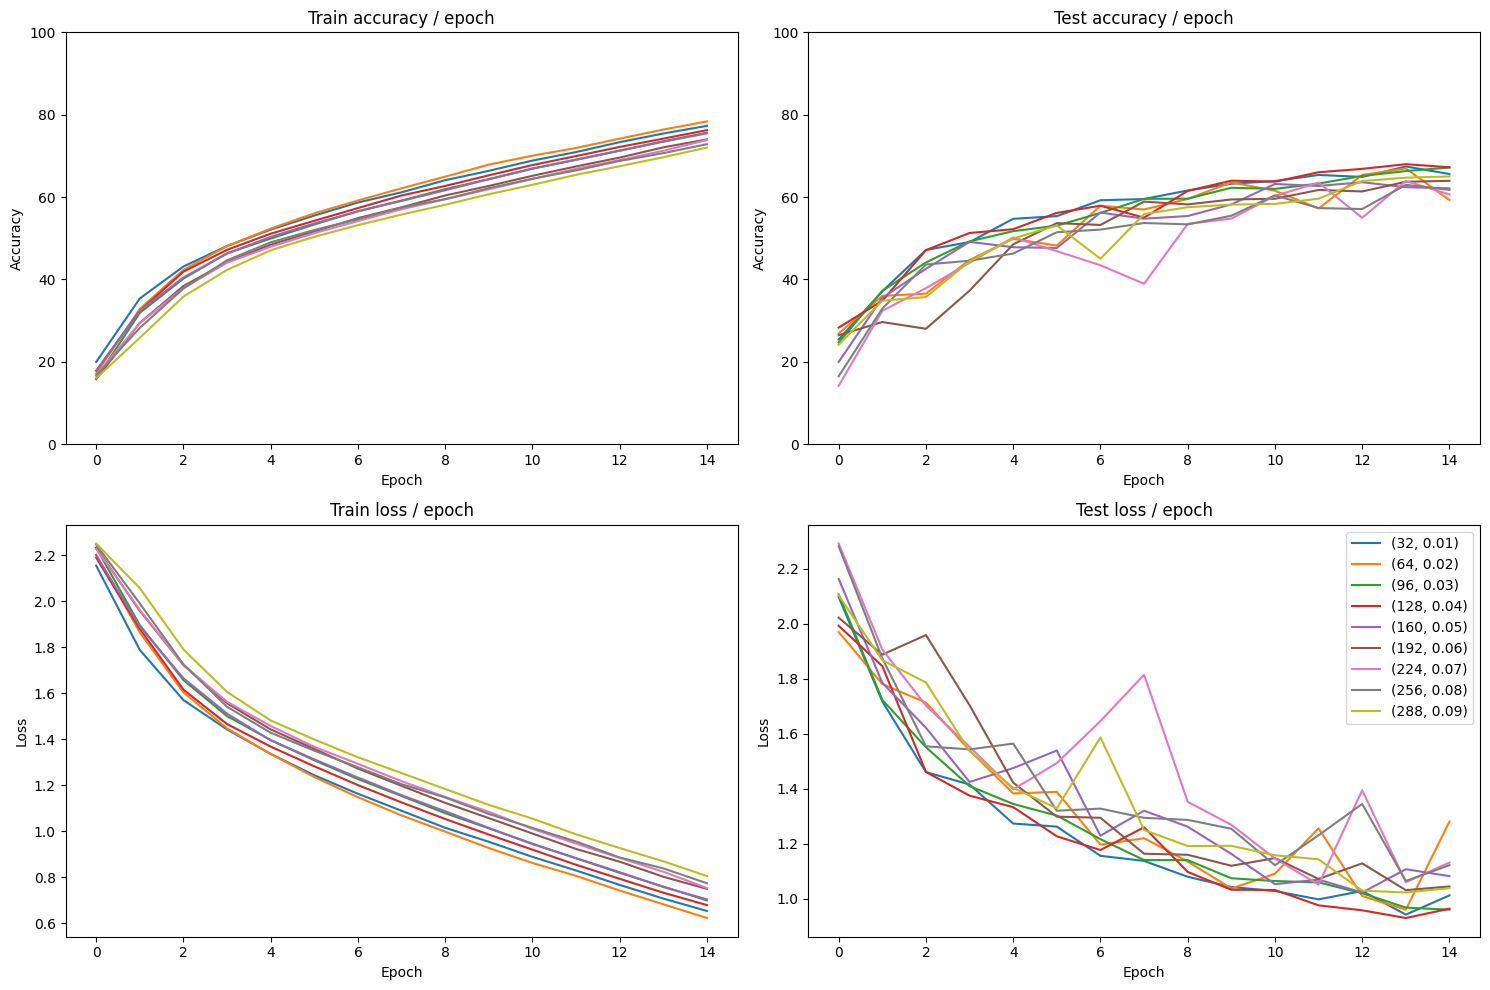

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

for lr, values in plots.items():
    ax[0].plot(values.acc_train, label=f"{BATCH_SIZE*lr, LR*lr}")
    ax[1].plot(values.acc_test, label=f"{BATCH_SIZE*lr, LR*lr}")
    ax[2].plot(values.loss_train, label=f"{BATCH_SIZE*lr, LR*lr}")
    ax[3].plot(values.loss_test, label=f"{BATCH_SIZE*lr, LR*lr}")

ax[0].set_title("Train accuracy / epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim([0, 100])

ax[1].set_title("Test accuracy / epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_ylim([0, 100])

ax[2].set_title("Train loss / epoch")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Loss")

ax[3].set_title("Test loss / epoch")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Loss")

plt.legend()
plt.tight_layout()
plt.savefig("linear_scaling.pdf", dpi=100, bbox_inches="tight")
plt.show()

## Influence of _batch size_


In [25]:
plots_batchsize = {}
for batch_size in [2**n for n in range(4, 11)]:  # 16 à 1024 par puissance de 2
    plots_batchsize[lr] = main(batch_size, LR, epochs=15, cuda=cuda)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

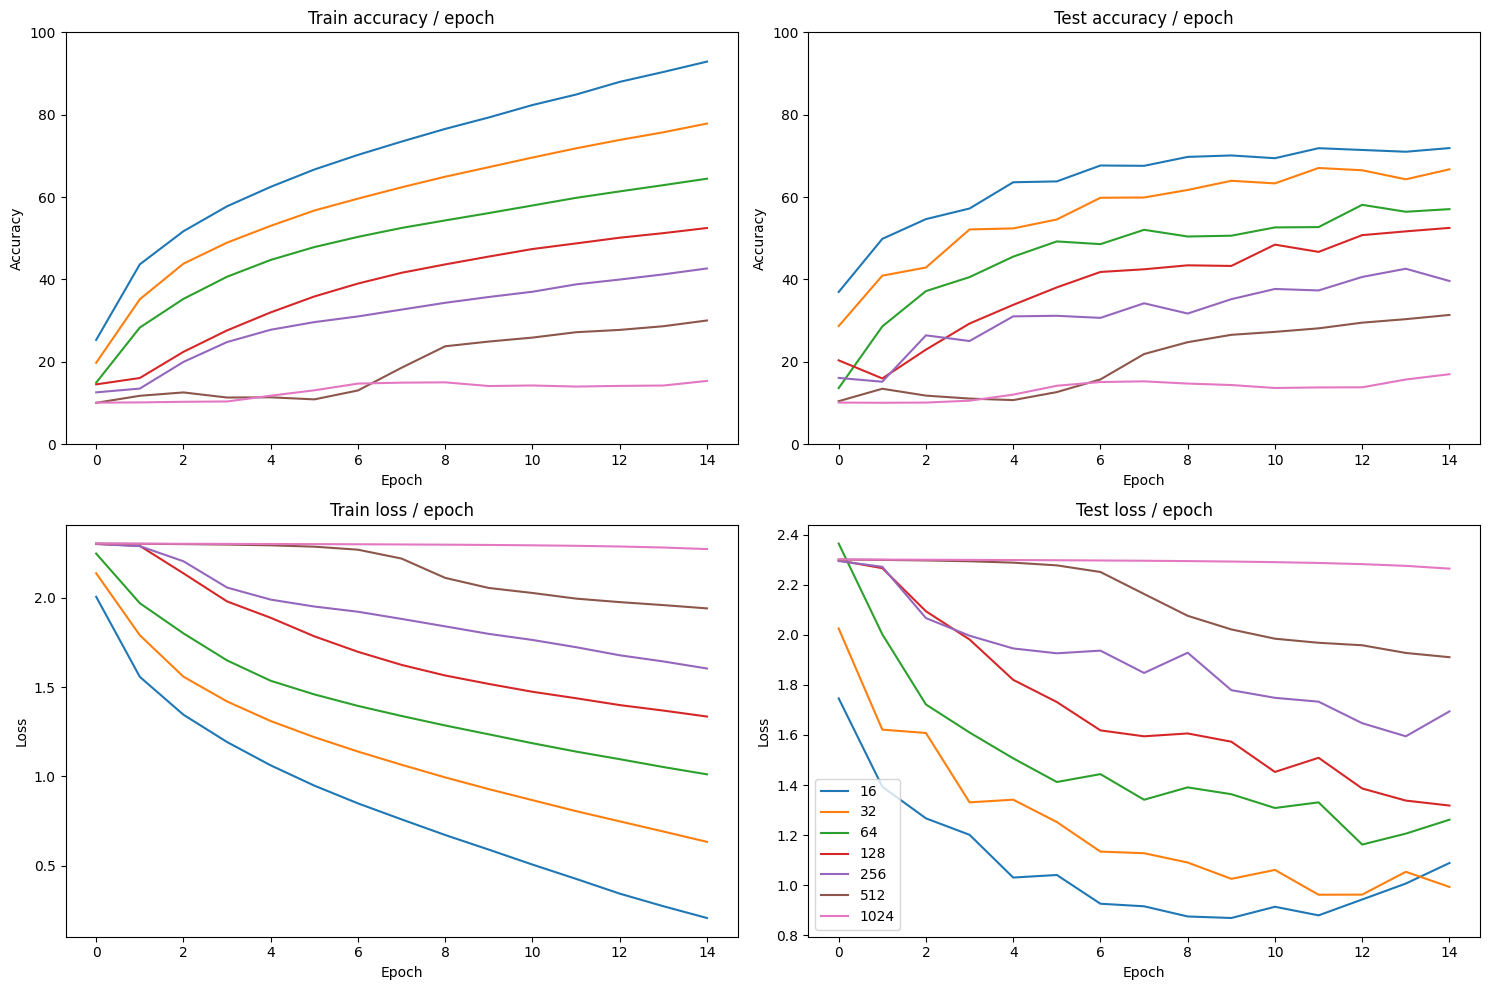

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

for batch_size, values in plots_batchsize.items():
    ax[0].plot(values.acc_train, label=f"{batch_size}")
    ax[1].plot(values.acc_test, label=f"{batch_size}")
    ax[2].plot(values.loss_train, label=f"{batch_size}")
    ax[3].plot(values.loss_test, label=f"{batch_size}")

ax[0].set_title("Train accuracy / epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim([0, 100])

ax[1].set_title("Test accuracy / epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_ylim([0, 100])

ax[2].set_title("Train loss / epoch")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Loss")

ax[3].set_title("Test loss / epoch")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Loss")

plt.legend()
plt.tight_layout()
plt.savefig("batch_size_influence.pdf", dpi=100, bbox_inches="tight")
plt.show()

## Influence of _learning rate_


In [27]:
plots_lr = {}
for lr in [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    plots_lr[lr] = main(BATCH_SIZE, lr, epochs=15, cuda=cuda)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

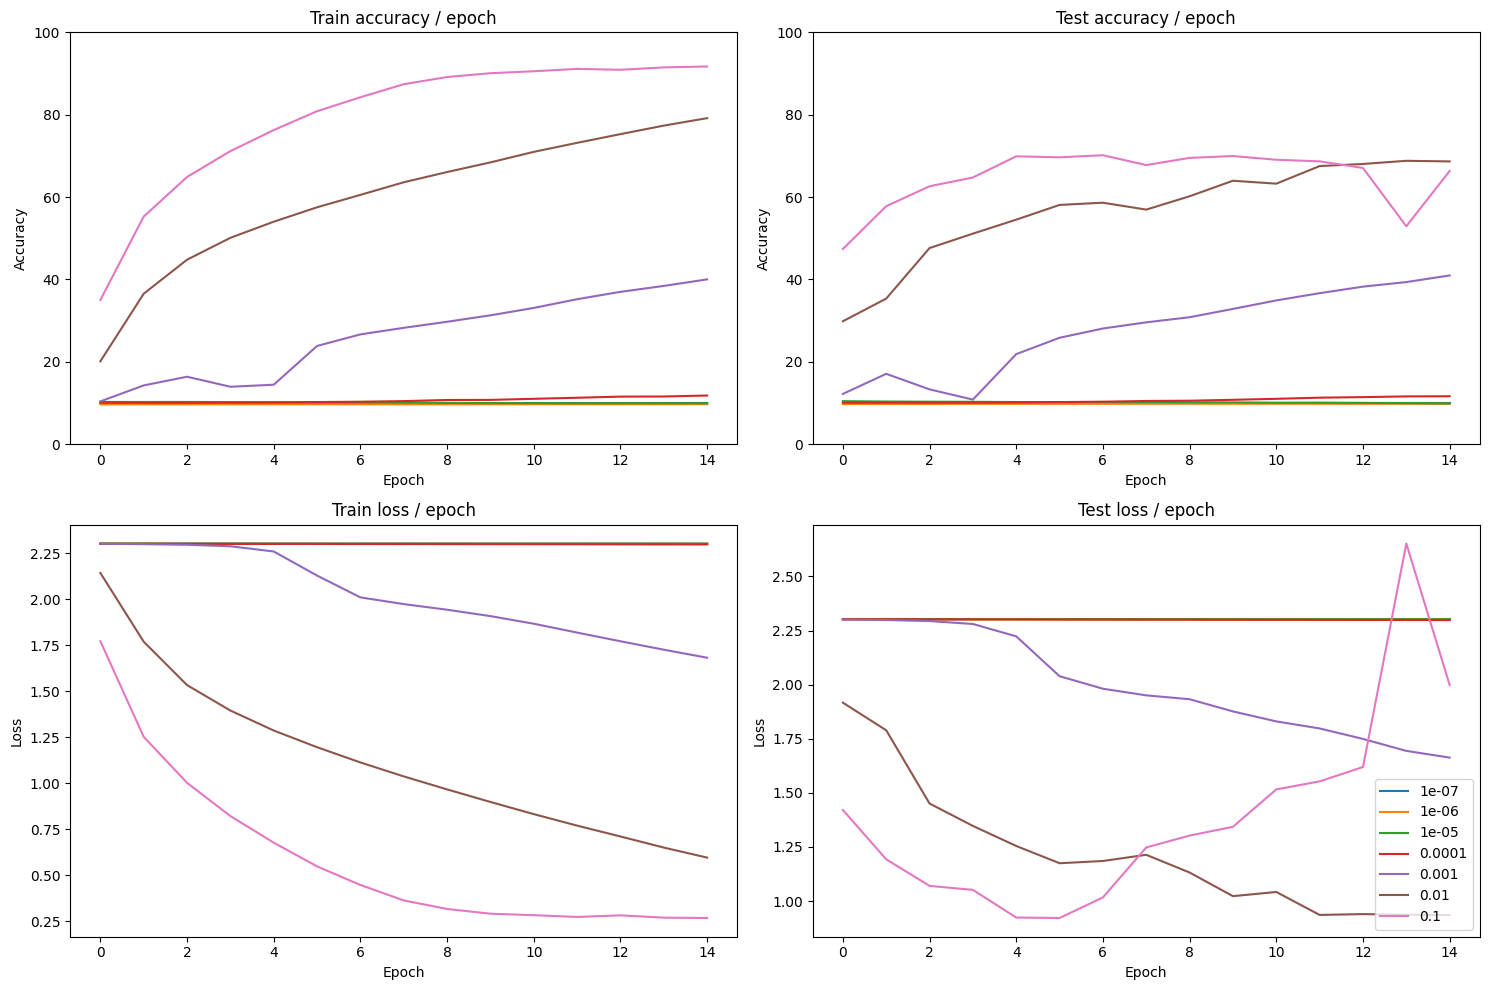

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

for lr, values in plots_lr.items():
    ax[0].plot(values.acc_train, label=f"{lr}")
    ax[1].plot(values.acc_test, label=f"{lr}")
    ax[2].plot(values.loss_train, label=f"{lr}")
    ax[3].plot(values.loss_test, label=f"{lr}")

ax[0].set_title("Train accuracy / epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim([0, 100])

ax[1].set_title("Test accuracy / epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_ylim([0, 100])

ax[2].set_title("Train loss / epoch")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Loss")

ax[3].set_title("Test loss / epoch")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Loss")

plt.legend()
plt.tight_layout()
plt.savefig("learning_rate_influence.pdf", dpi=100, bbox_inches="tight")
plt.show()

## Main results

To be able to compare


In [5]:
BATCH_SIZE = 32
LR = 0.01
EPOCHS = 100

In [19]:
plots_base = main(BATCH_SIZE, LR, epochs=EPOCHS, cuda=cuda)

  0%|          | 0/100 [00:00<?, ?it/s]

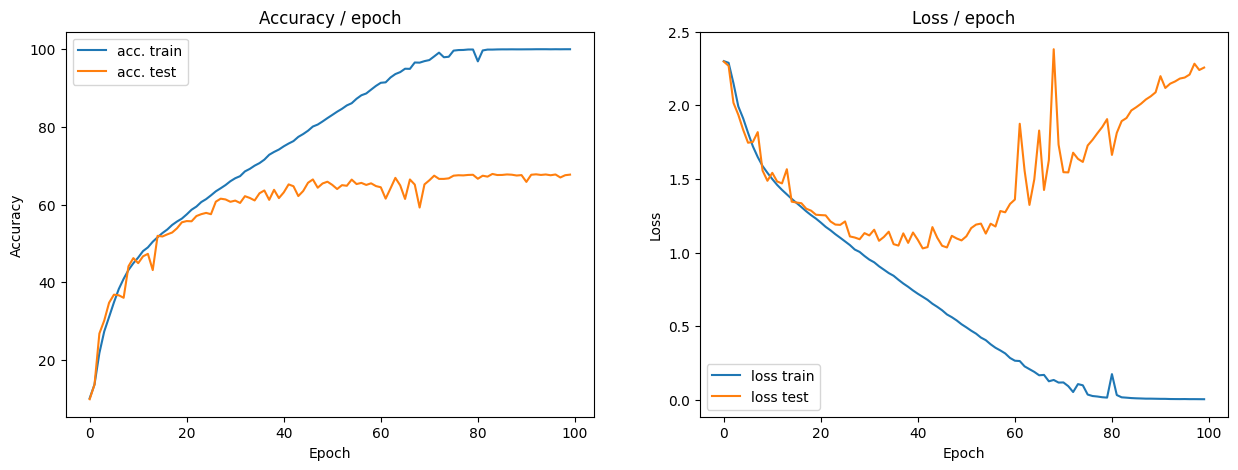

In [79]:
plots_base.plot("base_result")

In [104]:
print(plots_base.acc_train[0], plots_base.acc_train[-1])
print(plots_base.loss_train[0], plots_base.loss_train[-1])

10.129875319693095 99.99800191815856
2.300784748838381 0.0029052681875560444


In [105]:
print(plots_base.acc_test[0], plots_base.acc_test[-1])
print(plots_base.loss_test[0], plots_base.loss_test[-1])

9.889240506329115 67.71162974683544
2.297621011734009 2.257024153878417


: 

# Results improvements


## Standardization of examples


In [21]:
plots_standardization = main(BATCH_SIZE, LR, epochs=EPOCHS, cuda=cuda, transform="normalize")

  0%|          | 0/100 [00:00<?, ?it/s]

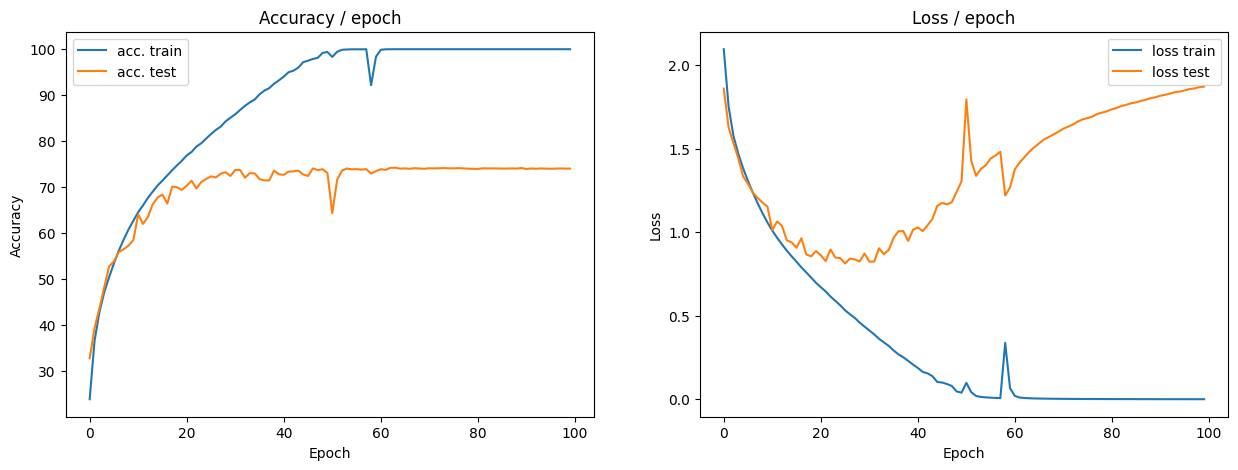

In [23]:
plots_standardization.plot(save_name="standardization")

In [59]:
import numpy as np
from sklearn.decomposition import PCA
from torchvision.transforms import Lambda


def pca_whitening(image):
    """
    Apply PCA whitening to an image. Assumes the input is a 3D numpy array (H x W x C).
    """
    flat_img = image.reshape(-1, 3)
    # Apply PCA
    pca = PCA(whiten=True)
    whitened = pca.fit_transform(flat_img)
    # Reshape to original dimensions
    whitened_img = whitened.reshape(image.shape)
    return torch.from_numpy(whitened_img).float()


def l1_normalization(image):
    """
    Apply L1 normalization to an image.
    """
    norm = torch.norm(image.reshape(-1), p=1)
    return image / norm


def l2_normalization(image):
    """
    Apply L2 normalization to an image.
    """
    norm = torch.norm(image.reshape(-1), p=2)
    return image / norm


def minmax_normalization(image):
    """
    Apply Min-Max normalization to an image.
    """
    min_val = torch.min(image)
    max_val = torch.max(image)
    return (image - min_val) / (max_val - min_val)

In [61]:
# Define transforms for each normalization technique
transformations = {
    "standard": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.447), (0.202, 0.199, 0.201)),
        ]
    ),
    "gcn": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Lambda(lambda x: (x - x.mean()) / (x.std() + 1e-7)),
        ]
    ),
    "pca": transforms.Compose(
        [
            transforms.ToTensor(),
            Lambda(lambda x: pca_whitening(x.numpy())),
        ]
    ),
    "l1_norm": transforms.Compose(
        [
            transforms.ToTensor(),
            Lambda(l1_normalization),
        ]
    ),
    "l2_norm": transforms.Compose(
        [
            transforms.ToTensor(),
            Lambda(l2_normalization),
        ]
    ),
    "minmax": transforms.Compose(
        [
            transforms.ToTensor(),
            Lambda(minmax_normalization),
        ]
    ),
}

# Load CIFAR-10 data
trainset = datasets.CIFAR10(PATH, train=True)
testset = datasets.CIFAR10(PATH, train=False)

plots_standardization = {}

for norm_type in transformations:
    print(f"Training with {norm_type} normalization")
    transform = transformations[norm_type]

    # Apply transformations
    trainset.transform = transform
    train = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=cuda, num_workers=2)

    testset.transform = transform
    test = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=cuda, num_workers=2)

    # Initialize the model
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), LR)

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    plots_standardization[norm_type] = AccLossPlot()
    for i in tqdm(range(EPOCHS)):
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)

        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)

        # plot
        plots_standardization[norm_type].update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

Training with standard normalization


  0%|          | 0/100 [00:00<?, ?it/s]

Training with gcn normalization


  0%|          | 0/100 [00:00<?, ?it/s]

Training with pca normalization


  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/valinquish/DAC/.venv/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/valinquish/DAC/.venv/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/valinquish/DAC/.venv/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/valinquish/DAC/.venv/lib/python3.9/site-packages/torchvision/datasets/cifar.py", line 118, in __getitem__
    img = self.transform(img)
  File "/home/valinquish/DAC/.venv/lib/python3.9/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
  File "/home/valinquish/DAC/.venv/lib/python3.9/site-packages/torchvision/transforms/transforms.py", line 486, in __call__
    return self.lambd(img)
  File "/tmp/ipykernel_316/3665804787.py", line 18, in <lambda>
    Lambda(lambda x: pca_whitening(x.numpy())),
  File "/tmp/ipykernel_316/2263028768.py", line 13, in pca_whitening
    whitened = pca.fit_transform(flat_img)
  File "/home/valinquish/DAC/.venv/lib/python3.9/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/home/valinquish/DAC/.venv/lib/python3.9/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/valinquish/DAC/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py", line 460, in fit_transform
    U, S, Vt = self._fit(X)
  File "/home/valinquish/DAC/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py", line 483, in _fit
    X = self._validate_data(
  File "/home/valinquish/DAC/.venv/lib/python3.9/site-packages/sklearn/base.py", line 605, in _validate_data
    out = check_array(X, input_name="X", **check_params)
  File "/home/valinquish/DAC/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py", line 938, in check_array
    raise ValueError(
ValueError: Expected 2D array, got 1D array instead:
array=[0.52156866 0.5254902  0.5411765  ... 0.4509804  0.46666667 0.4392157 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.


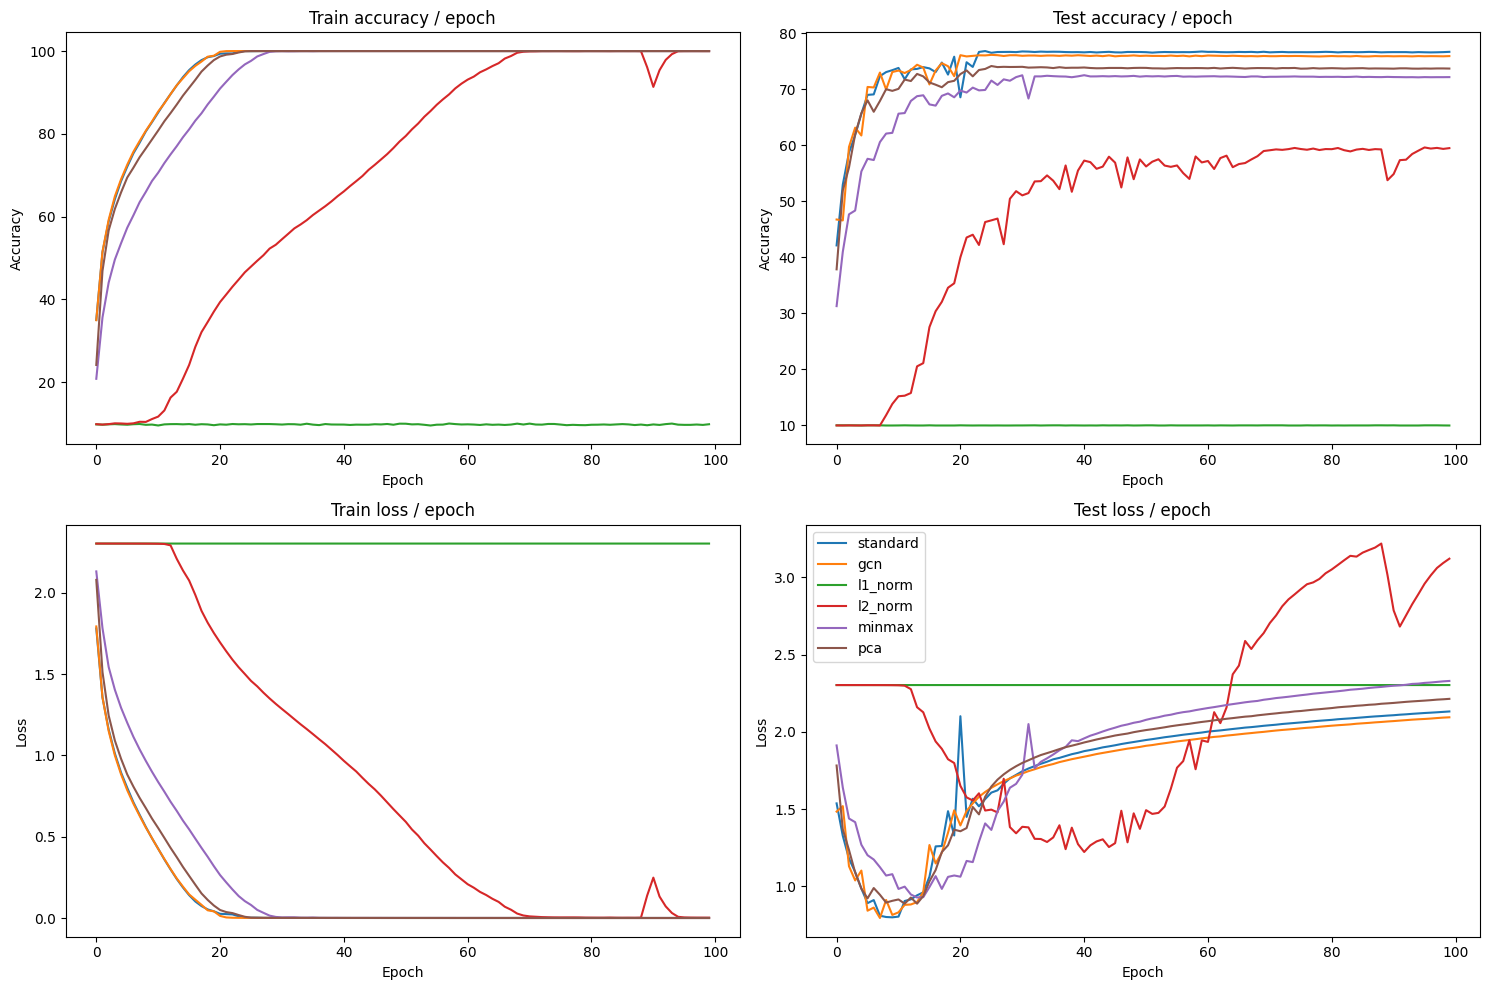

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

for norm_type, values in plots_standardization.items():
    ax[0].plot(values.acc_train, label=f"{norm_type}")
    ax[1].plot(values.acc_test, label=f"{norm_type}")
    ax[2].plot(values.loss_train, label=f"{norm_type}")
    ax[3].plot(values.loss_test, label=f"{norm_type}")

ax[0].set_title("Train accuracy / epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")

ax[1].set_title("Test accuracy / epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")

ax[2].set_title("Train loss / epoch")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Loss")

ax[3].set_title("Test loss / epoch")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Loss")

plt.legend()
plt.tight_layout()
plt.savefig("standardization_influence.pdf", dpi=100, bbox_inches="tight")
plt.show()

Bonus : https://jermwatt.github.io/control-notes/posts/zca_sphereing/ZCA_Sphereing.html

ça a l'air relou


## Increase in the number of training examples by _data increase_


In [24]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0)  # batch size
        output = self.features(input)  # output of the conv layers
        output = output.view(bsize, -1)  # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output)  # we compute the output of the fc layers
        return output

In [25]:
plots_dataincrease = main(BATCH_SIZE, LR, epochs=EPOCHS, cuda=cuda, transform="augmentation")

  0%|          | 0/100 [00:00<?, ?it/s]

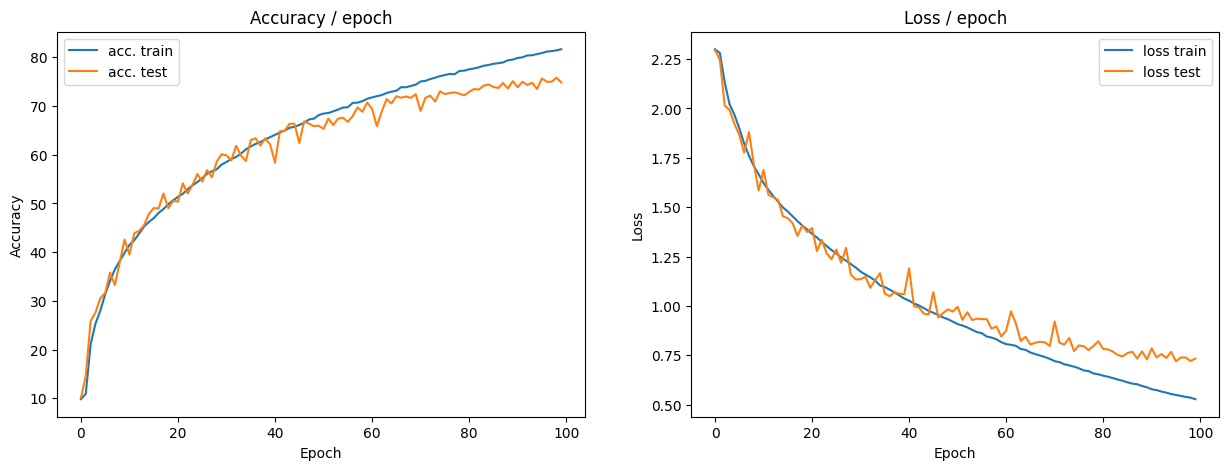

In [90]:
plots_dataincrease.plot(save_name="dataincrease")

Bonus : https://pytorch.org/vision/main/transforms.html


## Variants on the optimization algorithm


In [27]:
plots_scheduler = main(BATCH_SIZE, LR, epochs=EPOCHS, cuda=cuda, scheduler=True)

  0%|          | 0/100 [00:00<?, ?it/s]

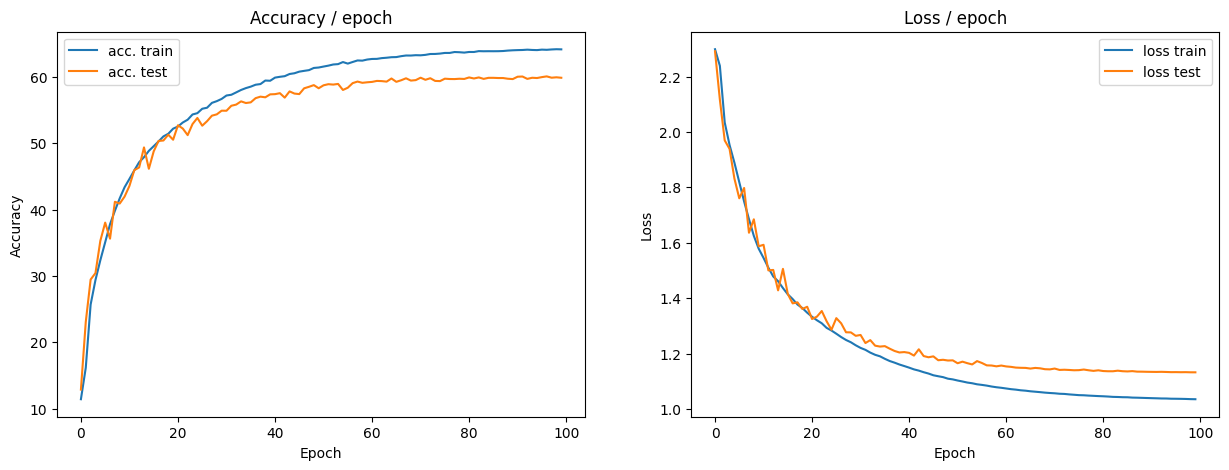

In [80]:
plots_scheduler.plot("optim_variants")

In [52]:
plots_schedulers = {}

schedulers = [
    lr_scheduler.ConstantLR,
    lr_scheduler.StepLR,
    lr_scheduler.ExponentialLR,
    lr_scheduler.PolynomialLR,
    lr_scheduler.LinearLR,
    lr_scheduler.CosineAnnealingLR,
]
lr_curves = {sch.__name__: [] for sch in schedulers}

for sch in schedulers:
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 0.1)

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    if sch.__name__ == "ExponentialLR":
        scheduler = sch(optimizer, gamma=0.95)
    elif sch.__name__ == "StepLR":
        scheduler = sch(optimizer, step_size=10)
    elif sch.__name__ == "CosineAnnealingLR":
        scheduler = sch(optimizer, T_max=EPOCHS)
    else:
        scheduler = sch(optimizer)

    train, test = get_dataset(BATCH_SIZE, cuda)
    plots_schedulers[sch.__name__] = AccLossPlot()

    for i in tqdm(range(EPOCHS)):
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)

        scheduler.step()
        plots_schedulers[sch.__name__].update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

        lr_curves[sch.__name__] += scheduler.get_last_lr()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

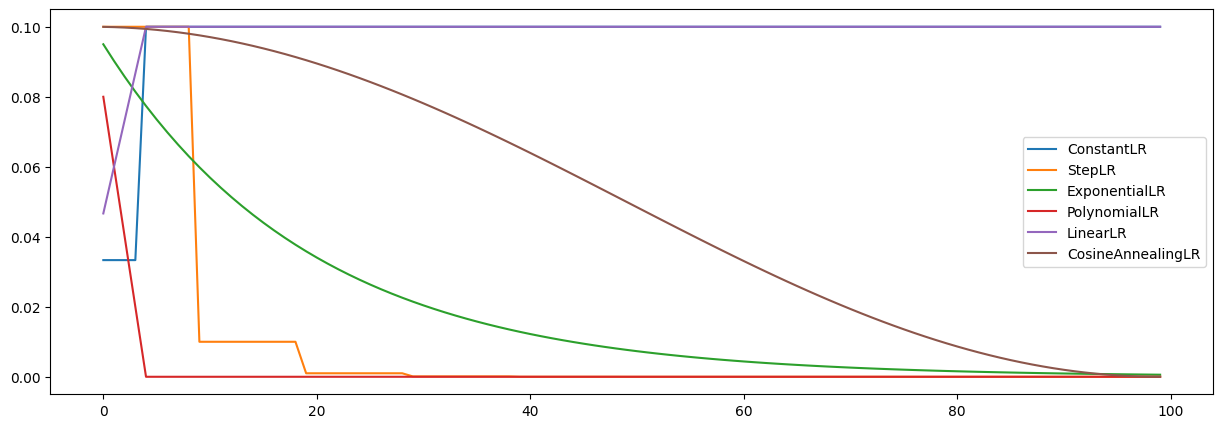

In [56]:
plt.figure(figsize=(15, 5))
for sch in schedulers:
    plt.plot(lr_curves[sch.__name__], label=sch.__name__)
plt.legend()
plt.savefig("schedulers_comparison.pdf", dpi=100, bbox_inches="tight")

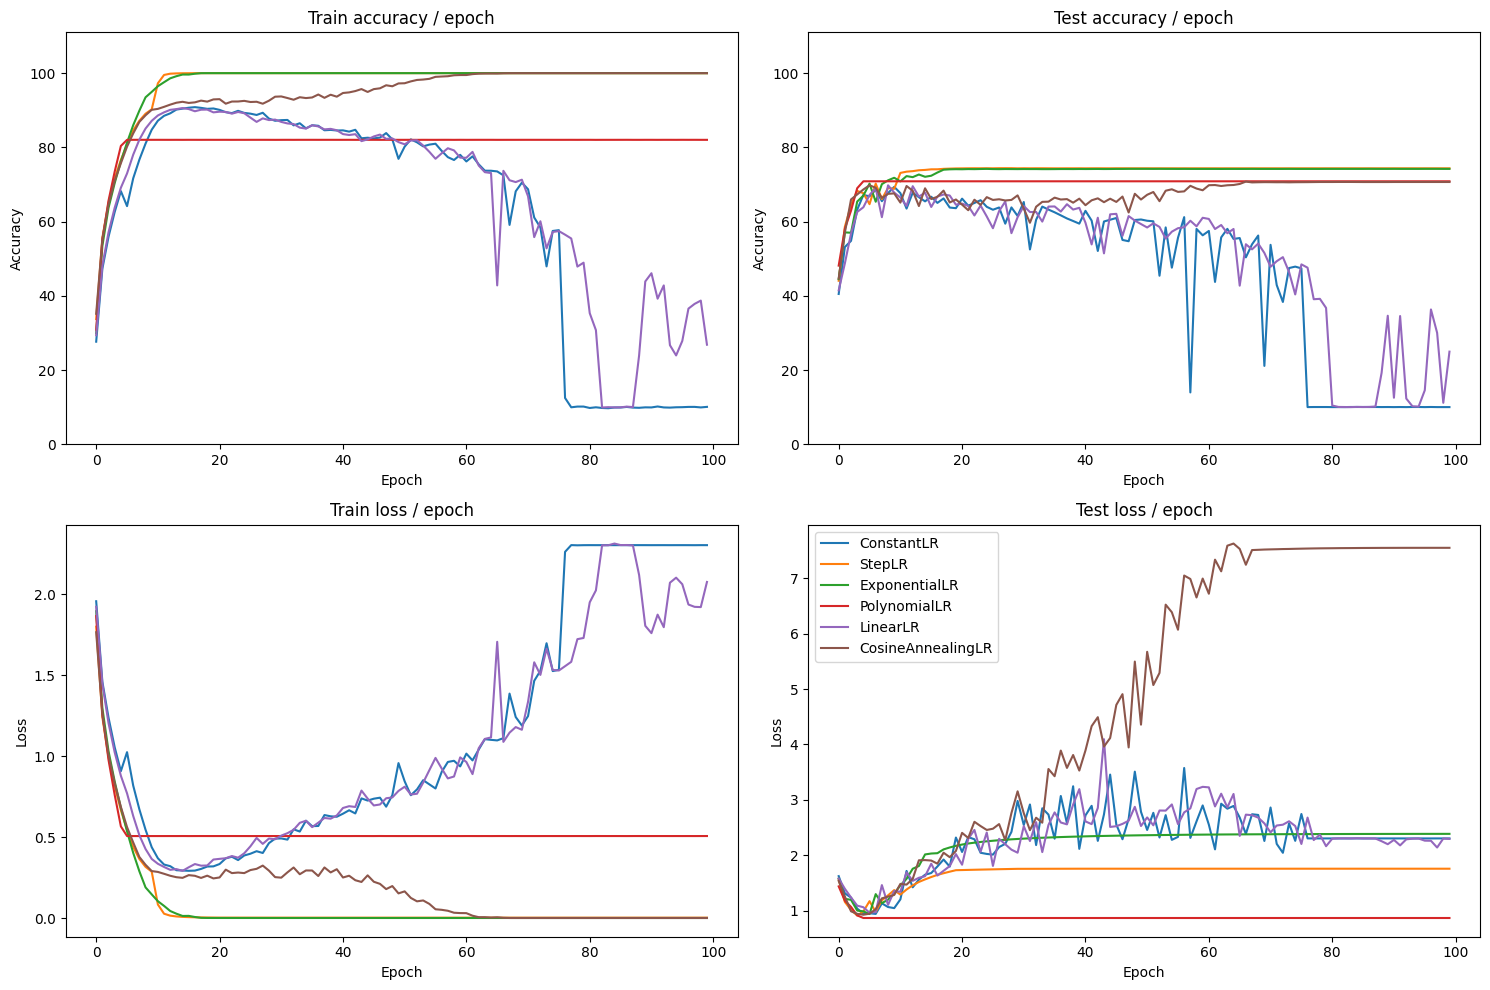

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

for sch, values in plots_schedulers.items():
    ax[0].plot(values.acc_train, label=f"{sch}")
    ax[1].plot(values.acc_test, label=f"{sch}")
    ax[2].plot(values.loss_train, label=f"{sch}")
    ax[3].plot(values.loss_test, label=f"{sch}")

ax[0].set_title("Train accuracy / epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim([0, 111])

ax[1].set_title("Test accuracy / epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_ylim([0, 111])

ax[2].set_title("Train loss / epoch")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Loss")

ax[3].set_title("Test loss / epoch")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Loss")

plt.legend()
plt.tight_layout()
plt.savefig("schedulers_influence.pdf", dpi=100, bbox_inches="tight")
plt.show()

In [8]:
plot_optimizers = {}

optimizers = [
    optim.SGD,
    optim.Adam,
    optim.AdamW,
    optim.Adagrad,
    optim.Adadelta,
    optim.RMSprop,
]

for opt in optimizers:
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    optimizer = opt(model.parameters(), LR)

    train, test = get_dataset(BATCH_SIZE, cuda)
    plot_optimizers[opt.__name__] = AccLossPlot()

    for i in tqdm(range(EPOCHS)):
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # Plots
        plot_optimizers[opt.__name__].update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

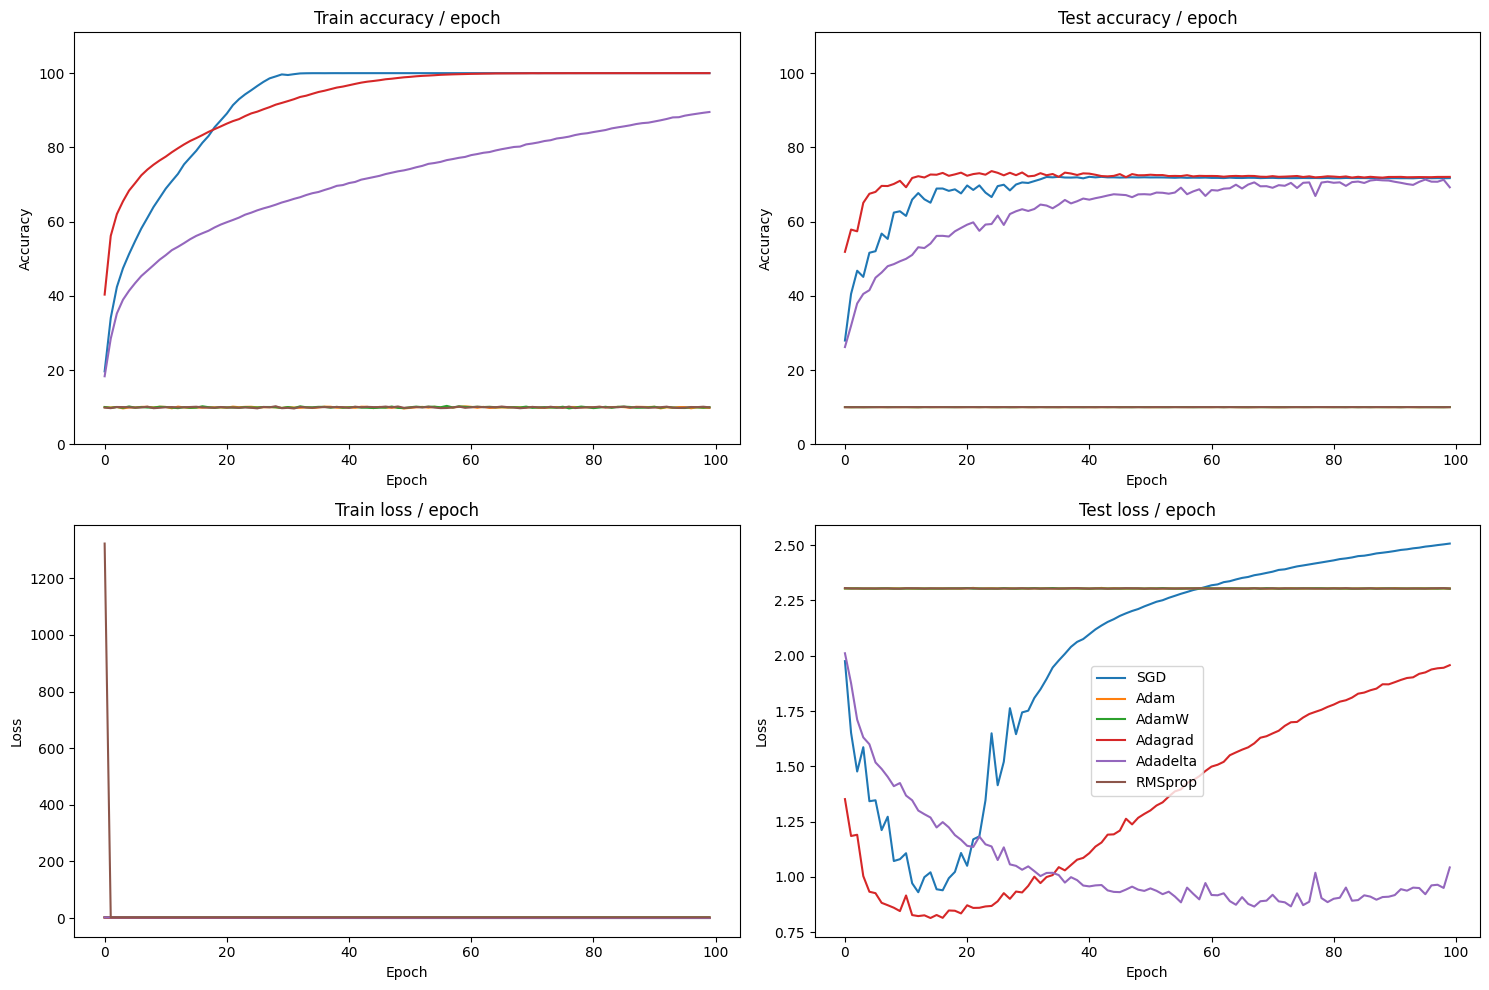

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

for opt, values in plot_optimizers.items():
    ax[0].plot(values.acc_train, label=f"{opt}")
    ax[1].plot(values.acc_test, label=f"{opt}")
    ax[2].plot(values.loss_train, label=f"{opt}")
    ax[3].plot(values.loss_test, label=f"{opt}")

ax[0].set_title("Train accuracy / epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim([0, 111])

ax[1].set_title("Test accuracy / epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_ylim([0, 111])

ax[2].set_title("Train loss / epoch")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Loss")

ax[3].set_title("Test loss / epoch")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Loss")

plt.legend()
plt.tight_layout()
plt.savefig("optimizers_influence.pdf", dpi=100, bbox_inches="tight")
plt.show()

## Regularization of the network by _dropout_


In [62]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self, p=0.5):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Dropout(p=p),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0)  # batch size
        output = self.features(input)  # output of the conv layers
        output = output.view(bsize, -1)  # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output)  # we compute the output of the fc layers
        return output

In [63]:
plots_dropout = main(BATCH_SIZE, LR, epochs=EPOCHS, cuda=cuda)

  0%|          | 0/100 [00:00<?, ?it/s]

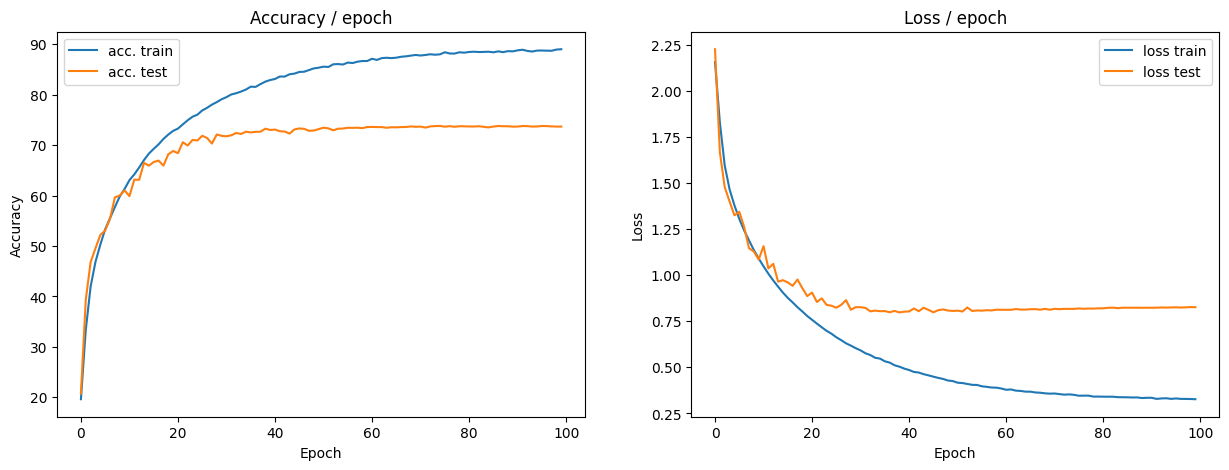

In [81]:
plots_dropout.plot("dropout")

In [83]:
plots_dropout_with_scheduler = main(BATCH_SIZE, LR, epochs=EPOCHS, cuda=cuda, scheduler=True)

  0%|          | 0/100 [00:00<?, ?it/s]

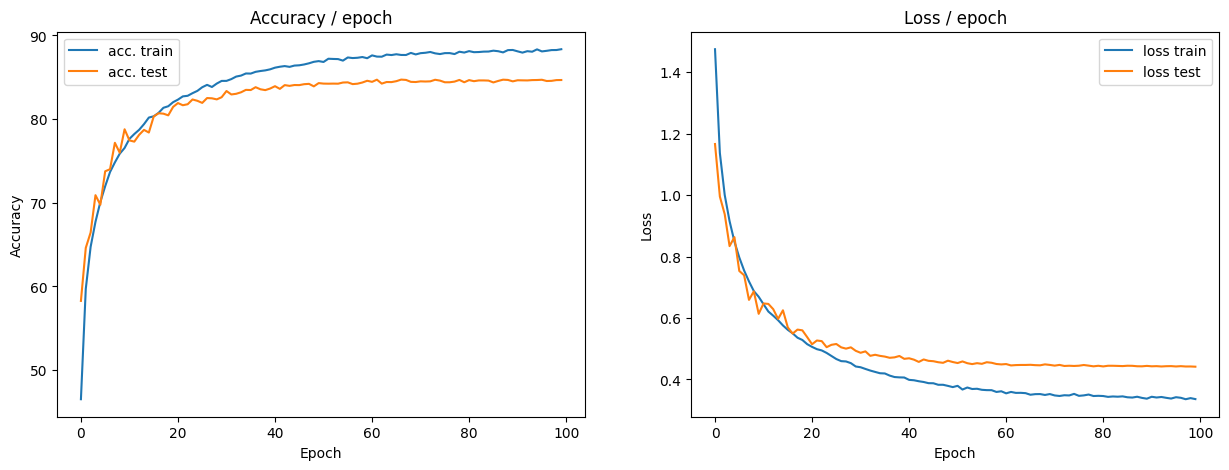

In [84]:
plots_dropout_with_scheduler.plot("dropout_with_scheduler")

### Influence of the hyperparamter

In [67]:
plots_dropout_hyperparameter = {}
for p in np.arange(0, 1.1, 0.1):
    class ConvNet(nn.Module):
        """
        This class defines the structure of the neural network
        """

        def __init__(self):
            super(ConvNet, self).__init__()
            # We first define the convolution and pooling layers as a features extractor
            self.features = nn.Sequential(
                nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d((2, 2), stride=2, padding=0),
                nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d((2, 2), stride=2, padding=0),
                nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d((2, 2), stride=2, padding=0),
            )
            # We then define fully connected layers as a classifier
            self.classifier = nn.Sequential(
                nn.Linear(1024, 1000),
                nn.ReLU(),
                nn.Dropout(p=p),
                nn.Linear(1000, 10),
                # Reminder: The softmax is included in the loss, do not put it here
            )

        # Method called when we apply the network to an input batch
        def forward(self, input):
            bsize = input.size(0)  # batch size
            output = self.features(input)  # output of the conv layers
            output = output.view(bsize, -1)  # we flatten the 2D feature maps into one 1D vector for each input
            output = self.classifier(output)  # we compute the output of the fc layers
            return output
    
    plots_dropout_hyperparameter[p] = main(BATCH_SIZE, LR, epochs=EPOCHS, cuda=cuda, scheduler=True)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

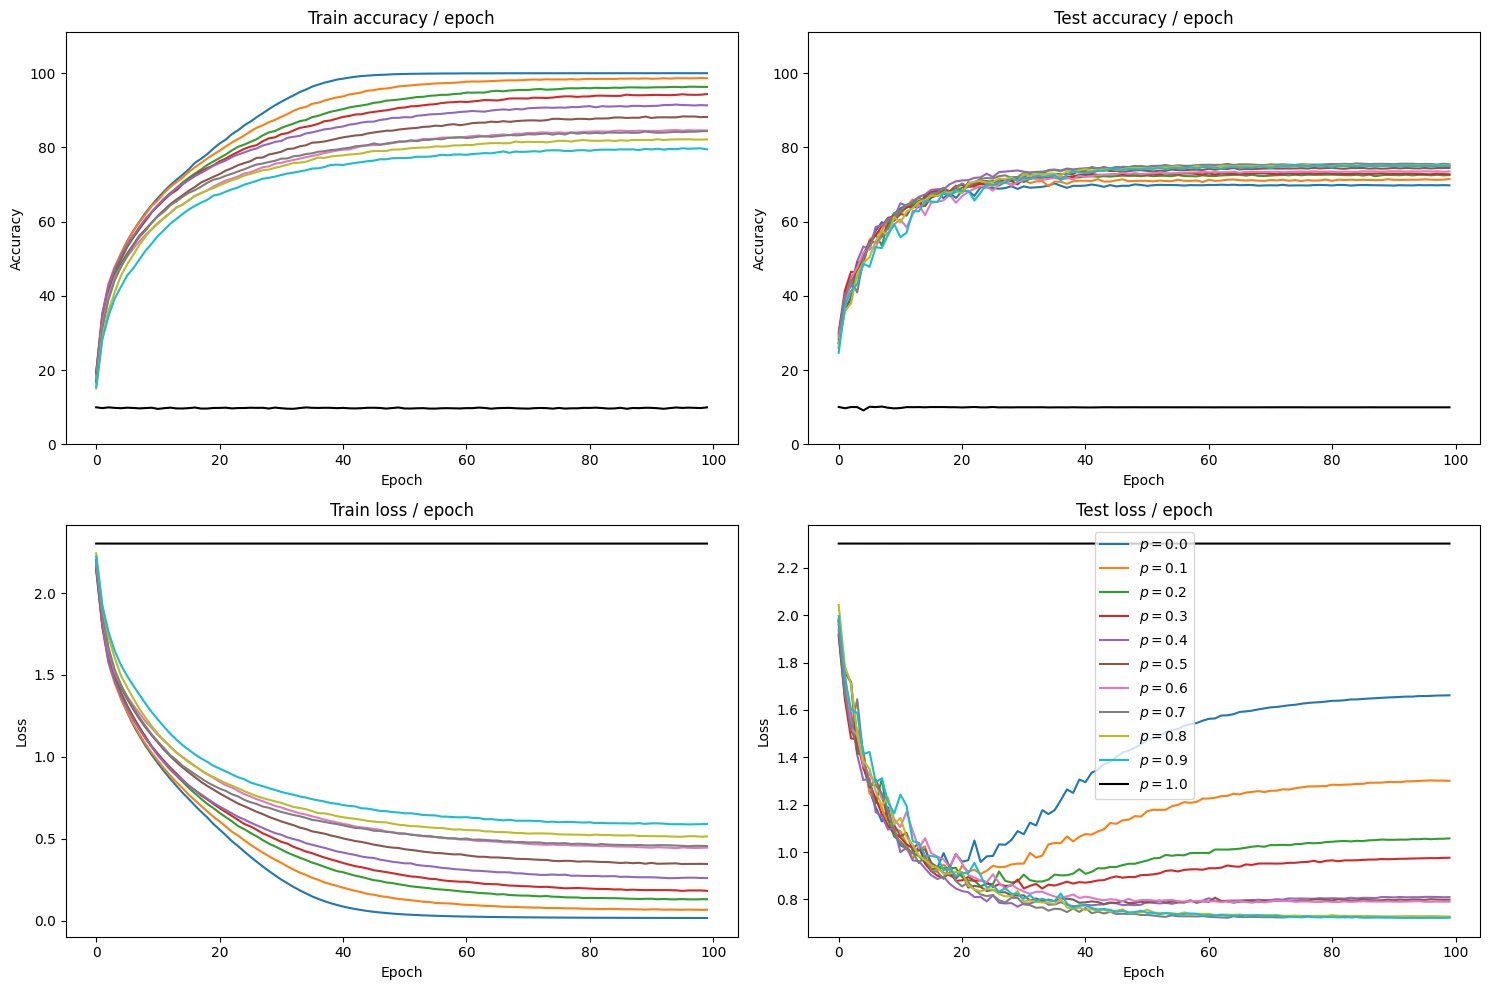

In [77]:
import matplotlib.colors as mcolors


colors = list(mcolors.TABLEAU_COLORS.keys()) + ["k"]

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax = ax.flatten()

for color, (p, values) in zip(colors, plots_dropout_hyperparameter.items()):
    ax[0].plot(values.acc_train, label=f"$p={p}$", color=color)
    ax[1].plot(values.acc_test, label=f"$p={p}$", color=color)
    ax[2].plot(values.loss_train, label=f"$p={p}$", color=color)
    ax[3].plot(values.loss_test, label=f"$p={p:.1f}$", color=color)

ax[0].set_title("Train accuracy / epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim([0, 111])

ax[1].set_title("Test accuracy / epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_ylim([0, 111])

ax[2].set_title("Train loss / epoch")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Loss")

ax[3].set_title("Test loss / epoch")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Loss")

plt.legend()
plt.tight_layout()
plt.savefig("dropout_hyperparameter.pdf", dpi=100, bbox_inches="tight")
plt.show()

## Use of _batch normalization_


In [72]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(
                32,
                64,
                (5, 5),
                stride=1,
                padding=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0)  # batch size
        output = self.features(input)  # output of the conv layers
        output = output.view(bsize, -1)  # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output)  # we compute the output of the fc layers
        return output

genre là c'eszt pas clair, est-ce qu'il faut garder le dropout ou pas, bref (pcq en général on fait les 2)


  0%|          | 0/100 [00:00<?, ?it/s]

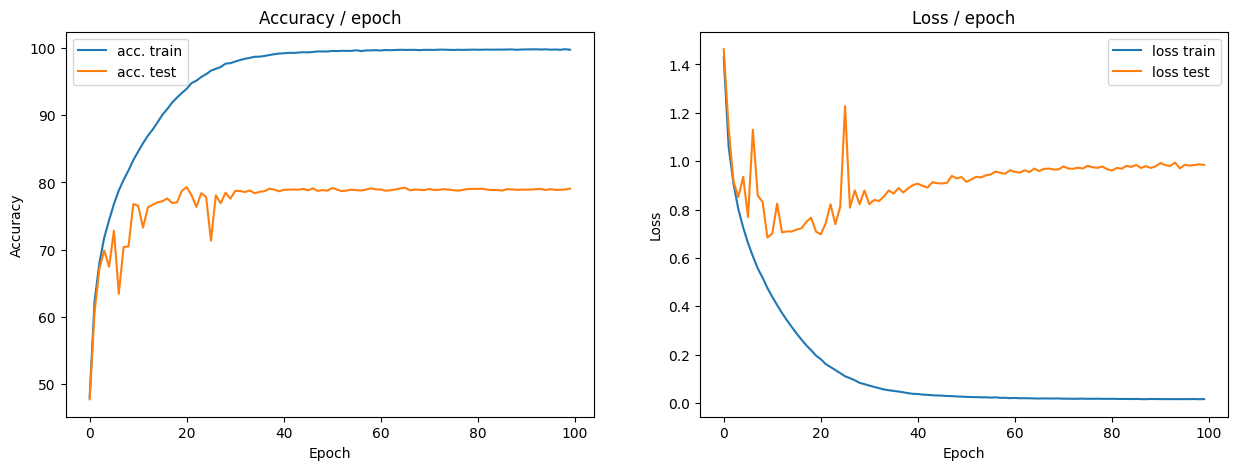

In [73]:
plots_batchnorm_with_dropout = main(BATCH_SIZE, LR, epochs=EPOCHS, cuda=cuda, scheduler=True)

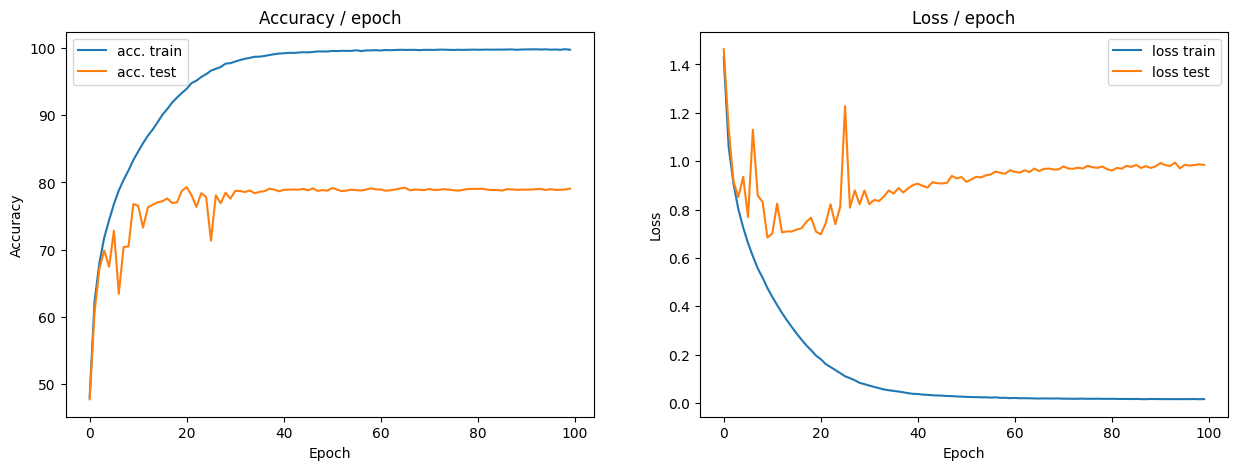

In [91]:
plots_batchnorm_with_dropout.plot("batchnorm_with_dropout")

sans dropout


In [69]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(
                32,
                64,
                (5, 5),
                stride=1,
                padding=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0)  # batch size
        output = self.features(input)  # output of the conv layers
        output = output.view(bsize, -1)  # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output)  # we compute the output of the fc layers
        return output

In [70]:
plots_batchnorm = main(BATCH_SIZE, LR, epochs=EPOCHS, cuda=cuda, scheduler=True)

  0%|          | 0/100 [00:00<?, ?it/s]

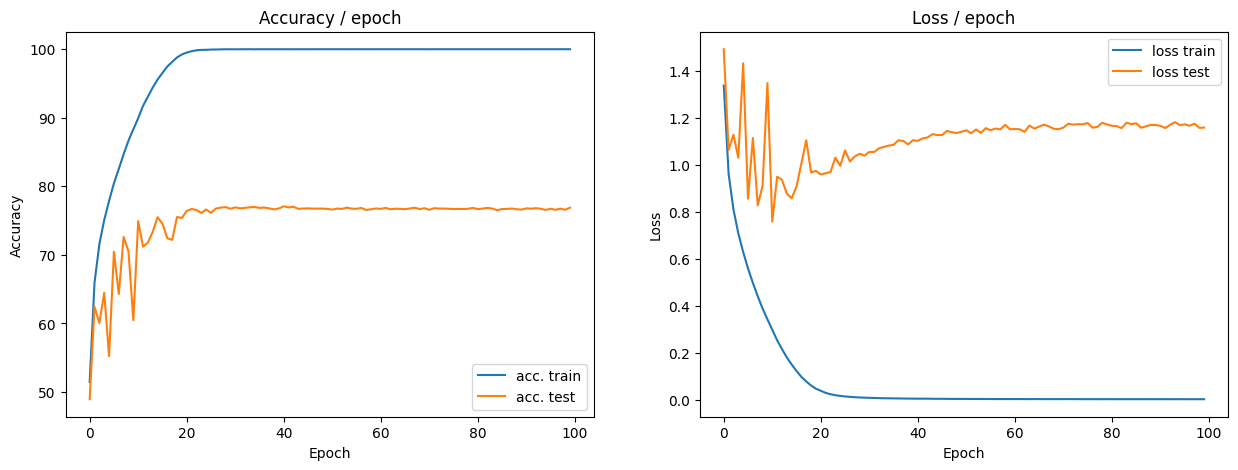

In [92]:
plots_batchnorm.plot("batchnorm")

## Data normalization + Data augmentation + Scheduler + Dropout + Batch Normalization

What if we combine everything?!


In [76]:
from torch import ceil_


class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, 10),
            # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0)  # batch size
        output = self.features(input)  # output of the conv layers
        output = output.view(bsize, -1)  # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output)  # we compute the output of the fc layers
        return output


def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    download = False
    if not os.path.isfile(f"{PATH}/cifar-10-python.tar.gz"):
        download = True

    transform_train = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201]),
            transforms.RandomCrop(28),
            transforms.RandomHorizontalFlip(),
        ]
    )
    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.491, 0.482, 0.447], std=[0.202, 0.199, 0.201]),
            transforms.CenterCrop(28),
        ]
    )

    train_dataset = datasets.CIFAR10(
        PATH,
        train=True,
        download=download,
        transform=transform_train,
    )
    val_dataset = datasets.CIFAR10(
        PATH,
        train=False,
        download=download,
        transform=transform_test,
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=cuda,
        num_workers=2,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=cuda,
        num_workers=2,
    )

    return train_loader, val_loader

In [77]:
plot_all = main(batch_size=BATCH_SIZE, lr=LR, epochs=EPOCHS, cuda=cuda, scheduler=True)

  0%|          | 0/100 [00:00<?, ?it/s]

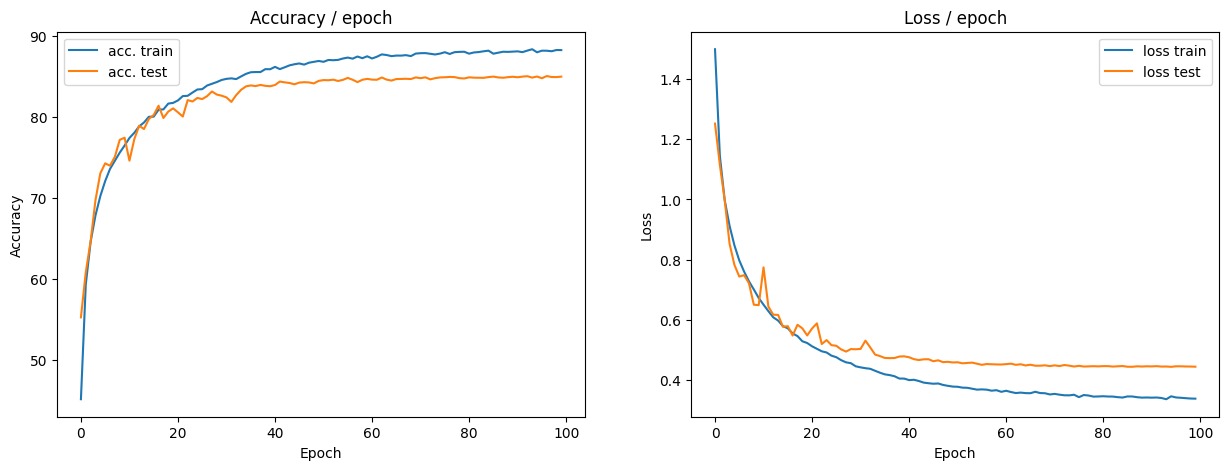

In [78]:
plot_all.plot(save_name="combined")

In [96]:
def main(
    batch_size=128,
    lr=0.1,
    epochs=5,
    cuda=False,
):
    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    optimizer = optim.Adagrad(model.parameters(), lr)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    # global loss_plot
    # loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in tqdm(range(epochs)):
        # print("=================\n==== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        scheduler.step()
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)
    # plot.plot(save_name)
    return plot

In [97]:
plot_all_adagrad = main(batch_size=BATCH_SIZE, lr=LR, epochs=EPOCHS, cuda=cuda)

  0%|          | 0/100 [00:00<?, ?it/s]

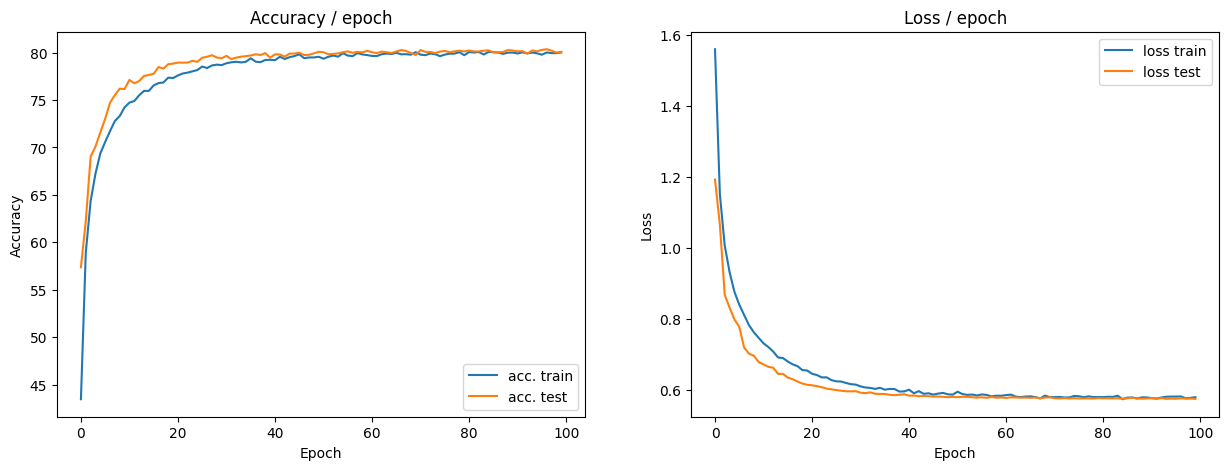

In [98]:
plot_all_adagrad.plot()

In [99]:
def main(
    batch_size=128,
    lr=0.1,
    epochs=5,
    cuda=False,
):
    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()

    if cuda:  # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    # global loss_plot
    # loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in tqdm(range(epochs)):
        # print("=================\n==== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        scheduler.step()
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)
    # plot.plot(save_name)
    return plot

In [100]:
plot_all_adam = main(batch_size=BATCH_SIZE, lr=LR, epochs=EPOCHS, cuda=cuda)

  0%|          | 0/100 [00:00<?, ?it/s]

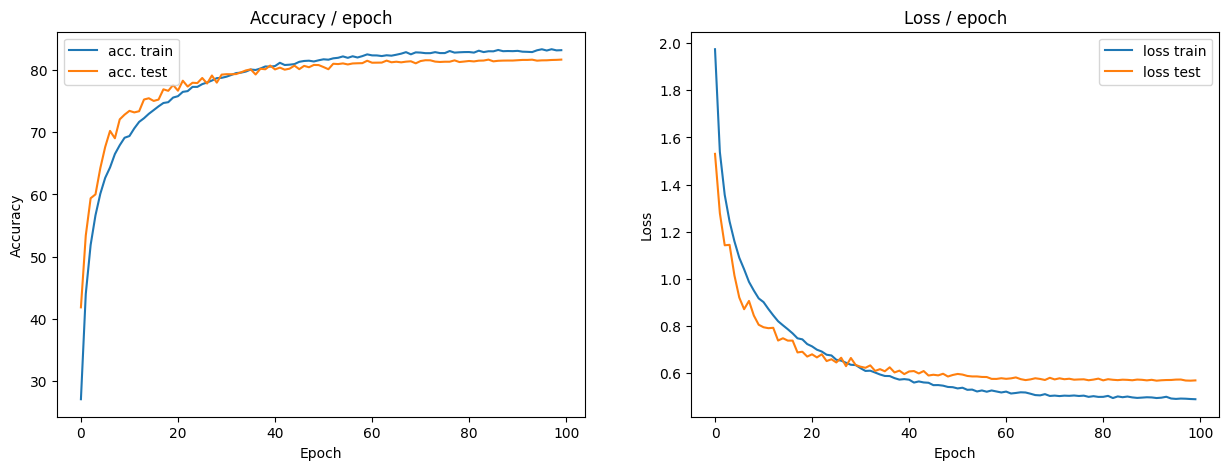

In [101]:
plot_all_adam.plot()